# Machine Learning Training

#### Variables & Features
In this portion, I will be using a machine learning model in order to determine the emission points and amounts. I have selected some variables that I find relavent to finding these values:

1. Weather
    1. Wind speed UGRD: 10m above ground
    2. Wind speed VGRD: 10m above ground
    3. Temperature
    4. Planetary Boundary Layer Height

In [1]:
import dataclasses
import datetime
import numpy as np
import pandas as pd
import zipfile
import glob
import matplotlib.pyplot as plt
import rioxarray
from PIL import Image
import rasterio
from rasterio.plot import show

## Importing data
### Weather - HRRR

In [3]:
import s3fs
import xarray as xr
import cartopy.crs as ccrs
import metpy
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import numcodecs as ncd

In [5]:
group_url = 's3://hrrrzarr/sfc/20220202/20220202_00z_anl.zarr/10m_above_ground/UGRD'
subgroup_url = f"{group_url}/10m_above_ground"

fs = s3fs.S3FileSystem(anon=True)    
ds = xr.open_mfdataset([s3fs.S3Map(url, s3=fs) for url in [group_url, subgroup_url]], engine='zarr')

projection = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                    globe=ccrs.Globe(semimajor_axis=6371229,
                                                     semiminor_axis=6371229))

ds = ds.rename(projection_x_coordinate="x", projection_y_coordinate="y")
ds = ds.metpy.assign_crs(projection.to_cf())
ds = ds.metpy.assign_latitude_longitude()    
ds#.UGRD.values

<xarray.Dataset>
Dimensions:                  (y: 1059, x: 1799)
Coordinates:
  * x                        (x) float64 -2.698e+06 -2.695e+06 ... 2.696e+06
  * y                        (y) float64 -1.587e+06 -1.584e+06 ... 1.587e+06
    metpy_crs                object Projection: lambert_conformal_conic
    latitude                 (y, x) float64 21.14 21.15 21.15 ... 47.85 47.84
    longitude                (y, x) float64 -122.7 -122.7 ... -60.95 -60.92
Data variables:
    UGRD                     (y, x) float16 dask.array<chunksize=(150, 150), meta=np.ndarray>
    forecast_period          timedelta64[ns] ...
    forecast_reference_time  datetime64[ns] ...
    height                   float64 ...
    pressure                 float64 ...
    time                     datetime64[ns] ...

Import methods for reading AWS weather files. The following code has been copied directly from MesoWest:

In [6]:
@dataclasses.dataclass
class ZarrId:
    run_hour: datetime.datetime
    level_type: str
    var_level: str
    var_name: str
    model_type: str
        
    def format_chunk_id(self, chunk_id):
        if self.model_type == "fcst": 
            # Extra id part since forecasts have an additional (time) dimension
            return "0." + str(chunk_id)
        else:
            return chunk_id

In [7]:
chunk_index = xr.open_zarr(s3fs.S3Map("s3://hrrrzarr/grid/HRRR_chunk_index.zarr", s3=fs))

lat_top = 38.40000
lat_bottom = 37
lon_top = -121.8
lon_bottom = -123.1

def check_boundaries(data):
    return (lat_bottom < data.latitude) & (data.latitude < lat_top) & (
        lon_bottom < data.longitude) & (data.longitude < lon_top)

area = chunk_index.where(check_boundaries, drop=True)
area

<xarray.Dataset>
Dimensions:     (x: 50, y: 59)
Coordinates:
  * x           (x) float64 -2.242e+06 -2.239e+06 ... -2.098e+06 -2.095e+06
  * y           (y) float64 1.197e+05 1.227e+05 ... 2.907e+05 2.937e+05
Data variables:
    chunk_id    (x, y) object dask.array<chunksize=(50, 59), meta=np.ndarray>
    chunk_x     (x, y) float64 dask.array<chunksize=(50, 59), meta=np.ndarray>
    chunk_y     (y, x) float64 dask.array<chunksize=(59, 50), meta=np.ndarray>
    in_chunk_x  (x, y) float64 dask.array<chunksize=(50, 59), meta=np.ndarray>
    in_chunk_y  (y, x) float64 dask.array<chunksize=(59, 50), meta=np.ndarray>
    index_x     (x, y) float64 dask.array<chunksize=(50, 59), meta=np.ndarray>
    index_y     (y, x) float64 dask.array<chunksize=(59, 50), meta=np.ndarray>
    latitude    (y, x) float64 dask.array<chunksize=(59, 50), meta=np.ndarray>
    longitude   (y, x) float64 dask.array<chunksize=(59, 50), meta=np.ndarray>

In [10]:
def create_s3_group_url(zarr_id, prefix=True):
    url = "s3://hrrrzarr/" if prefix else "" # Skip when using boto3
    url += zarr_id.run_hour.strftime(
        f"{zarr_id.level_type}/%Y%m%d/%Y%m%d_%Hz_{zarr_id.model_type}.zarr/")
    url += f"{zarr_id.var_level}/{zarr_id.var_name}"
    return url

def create_s3_subgroup_url(zarr_id, prefix=True):
    url = create_s3_group_url(zarr_id, prefix)
    url += f"/{zarr_id.var_level}"
    return url

def create_s3_chunk_url(zarr_id, chunk_id, prefix=False):
    url = create_s3_subgroup_url(zarr_id, prefix)
    url += f"/{zarr_id.var_name}/{zarr_id.format_chunk_id(chunk_id)}"
    return url

In [11]:
def get_unique(data):
    # We have to implement our own "unique" logic since missing values are NaN (a float) and the rest are string
    data = data.fillna(None).values.flatten()
    data = data[data != None]
    return np.unique(data)

chunk_ids = get_unique(area.chunk_id)

In [12]:
s3 = boto3.resource(service_name='s3', region_name='us-west-1', config=Config(signature_version=UNSIGNED))

def retrieve_object(s3, s3_url):
    obj = s3.Object('hrrrzarr', s3_url)
    return obj.get()['Body'].read()

zarr_id = ZarrId(
                run_hour=datetime.datetime(2020, 2, 2, 0),
                level_type="sfc",
                var_level="10m_above_ground",
                var_name="UGRD",
                model_type="anl"
                )

In [13]:
def decompress_chunk(zarr_id, compressed_data):
    buffer = ncd.blosc.decompress(compressed_data)
    
    dtype = "<f2"
    if zarr_id.var_level == "surface" and zarr_id.var_name == "PRES":
        dtype = "<f4"
        
    chunk = np.frombuffer(buffer, dtype=dtype)
    
    if zarr_id.model_type == "anl":
        data_array = np.reshape(chunk, (150, 150))
    else:
        entry_size = 22500
        data_array = np.reshape(chunk, (len(chunk)//entry_size, 150, 150))
        
    return data_array

In [14]:
def get_chunk(zarr_id, chunk_id):
    # retrieve data as before
    compressed_data = retrieve_object(s3, create_s3_chunk_url(zarr_id, chunk_id))
    chunk_data = decompress_chunk(zarr_id, compressed_data)
    
    # combine retrieved data with the chunk grid
    chunk_xarray = chunk_index.where(lambda x: x.chunk_id == chunk_id, drop=True)
    dimensions = ("y", "x") if zarr_id.model_type == "anl" else ("time", "y", "x")
    chunk_xarray[zarr_id.var_name] = (dimensions, chunk_data)
    return chunk_xarray

def get_chunks_combined(zarr_id, chunk_ids):
    chunks = [get_chunk(zarr_id, chunk_id) for chunk_id in chunk_ids]
    return xr.merge(chunks)

    
data = get_chunks_combined(zarr_id, chunk_ids)
data = data.where(check_boundaries, drop=True)
data

<xarray.Dataset>
Dimensions:     (x: 50, y: 59)
Coordinates:
  * x           (x) float64 -2.242e+06 -2.239e+06 ... -2.098e+06 -2.095e+06
  * y           (y) float64 1.197e+05 1.227e+05 ... 2.907e+05 2.937e+05
Data variables:
    chunk_id    (x, y) object dask.array<chunksize=(50, 59), meta=np.ndarray>
    chunk_x     (x, y) float64 dask.array<chunksize=(50, 59), meta=np.ndarray>
    chunk_y     (y, x) float64 dask.array<chunksize=(59, 50), meta=np.ndarray>
    in_chunk_x  (x, y) float64 dask.array<chunksize=(50, 59), meta=np.ndarray>
    in_chunk_y  (y, x) float64 dask.array<chunksize=(59, 50), meta=np.ndarray>
    index_x     (x, y) float64 dask.array<chunksize=(50, 59), meta=np.ndarray>
    index_y     (y, x) float64 dask.array<chunksize=(59, 50), meta=np.ndarray>
    latitude    (y, x) float64 dask.array<chunksize=(59, 50), meta=np.ndarray>
    longitude   (y, x) float64 dask.array<chunksize=(59, 50), meta=np.ndarray>
    UGRD        (y, x) float16 dask.array<chunksize=(59, 50), meta=np.ndarray>

In [15]:
data.UGRD.values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float16)

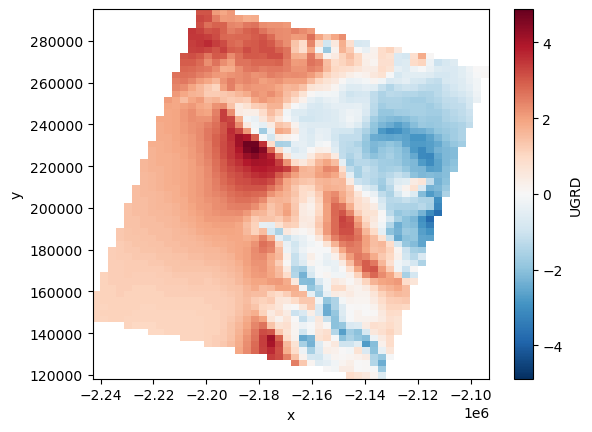

In [16]:
data.UGRD.plot()

In [18]:
start = datetime.datetime(2018, 1, 1, 0)
times = [start + datetime.timedelta(days=day_delta) for day_delta in range(2)]

zarr_ids = [dataclasses.replace(zarr_id, run_hour=time) for time in times]

def get_data(zarr_ids, chunk_ids, is_forecast):
    datasets = []
    for zarr_id in zarr_ids:
        data = get_chunks_combined(zarr_id, chunk_ids)
        
#        The following line, which creates the boundaries, makes all values NaNs
#        Removing this line gives us non-NaN values, but instead it is all chunks
        data = data.where(check_boundaries, drop=True)
    
        new_time_dimension = "run_time" if is_forecast else "time"
        data[new_time_dimension] = zarr_id.run_hour
        datasets.append(data)
    ds = xr.concat(datasets, dim=new_time_dimension, combine_attrs="override")
    return ds
    
over_time = get_data(zarr_ids, chunk_ids, False)
over_time

<xarray.Dataset>
Dimensions:     (time: 2, x: 50, y: 59)
Coordinates:
  * x           (x) float64 -2.242e+06 -2.239e+06 ... -2.098e+06 -2.095e+06
  * y           (y) float64 1.197e+05 1.227e+05 ... 2.907e+05 2.937e+05
  * time        (time) datetime64[ns] 2018-01-01 2018-01-02
Data variables:
    chunk_id    (time, x, y) object dask.array<chunksize=(1, 50, 59), meta=np.ndarray>
    chunk_x     (time, x, y) float64 dask.array<chunksize=(1, 50, 59), meta=np.ndarray>
    chunk_y     (time, y, x) float64 dask.array<chunksize=(1, 59, 50), meta=np.ndarray>
    in_chunk_x  (time, x, y) float64 dask.array<chunksize=(1, 50, 59), meta=np.ndarray>
    in_chunk_y  (time, y, x) float64 dask.array<chunksize=(1, 59, 50), meta=np.ndarray>
    index_x     (time, x, y) float64 dask.array<chunksize=(1, 50, 59), meta=np.ndarray>
    index_y     (time, y, x) float64 dask.array<chunksize=(1, 59, 50), meta=np.ndarray>
    latitude    (time, y, x) float64 dask.array<chunksize=(1, 59, 50), meta=np.ndarray>
    longitude   (time, y, x) float64 dask.array<chunksize=(1, 59, 50), meta=np.ndarray>
    UGRD        (time, y, x) float16 dask.array<chunksize=(1, 59, 50), meta=np.ndarray>

In [19]:
over_time.latitude[0].values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [20]:
over_time.longitude[0].values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [21]:
(over_time.latitude.values).shape

(2, 59, 50)

In [22]:
(over_time.UGRD.values).shape

(2, 59, 50)

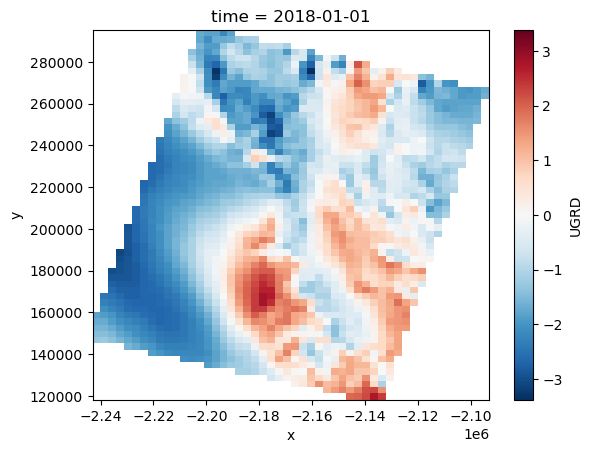

In [23]:
over_time.UGRD[0].plot()

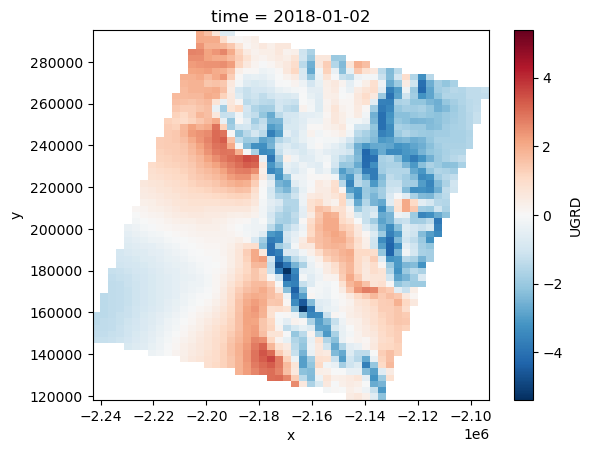

In [24]:
over_time.UGRD[1].plot()

In [25]:
over_time.UGRD[1]

<xarray.DataArray 'UGRD' (y: 59, x: 50)>
dask.array<getitem, shape=(59, 50), dtype=float16, chunksize=(59, 50), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 -2.242e+06 -2.239e+06 ... -2.098e+06 -2.095e+06
  * y        (y) float64 1.197e+05 1.227e+05 1.257e+05 ... 2.907e+05 2.937e+05
    time     datetime64[ns] 2018-01-02